In [11]:
library(dplyr)
library(ggplot2)
library(zeallot)
library(cowplot)

Warning message:
"pakiet 'cowplot' został zbudowany w wersji R 4.1.3"


In [3]:
analysis <- function(X, Y, display_plot=TRUE){
    spearman <- cor(X, Y, use="pairwise.complete.obs", method="spearman")
    pearson <- cor(X, Y, use="pairwise.complete.obs", method="pearson")
    print(c("Pearson", pearson))
    print(c("Spearman", spearman))
    if (display_plot) {
        ggplot() + geom_point(aes(x=X, y=Y))
    }
}

regression <- function(X, Y, display_plot=TRUE){
    r <- cor(X, Y, use="pairwise.complete.obs")
    Sx <- sd(X)
    Sy <- sd(Y)
    a <- r * Sy / Sx
    b <- mean(Y) - a * mean(X)

    if(display_plot){
        xs <- seq(min(X), max(X), 0.01)
        plt <- ggplot() +
            geom_point(aes(x=X, y=Y), alpha=0.5) +
            geom_line(aes(x = xs, y = a * xs + b), linewidth=1, col="red")
        show(plt)
    }

    return(c(a, b))
}

In [4]:
data <- read.csv("data/data.csv")
data2000 <- data %>% filter(year == 2000)
data2005 <- data %>% filter(year == 2005)
data2010 <- data %>% filter(year == 2010)
data2015 <- data %>% filter(year == 2015)
poland <- data %>% filter(country == "Poland")

[1] "Pearson"           "0.751975462736698"
[1] "Spearman"          "0.813541004769093"


Warning message:
"Removed 170 rows containing missing values (`geom_point()`)."


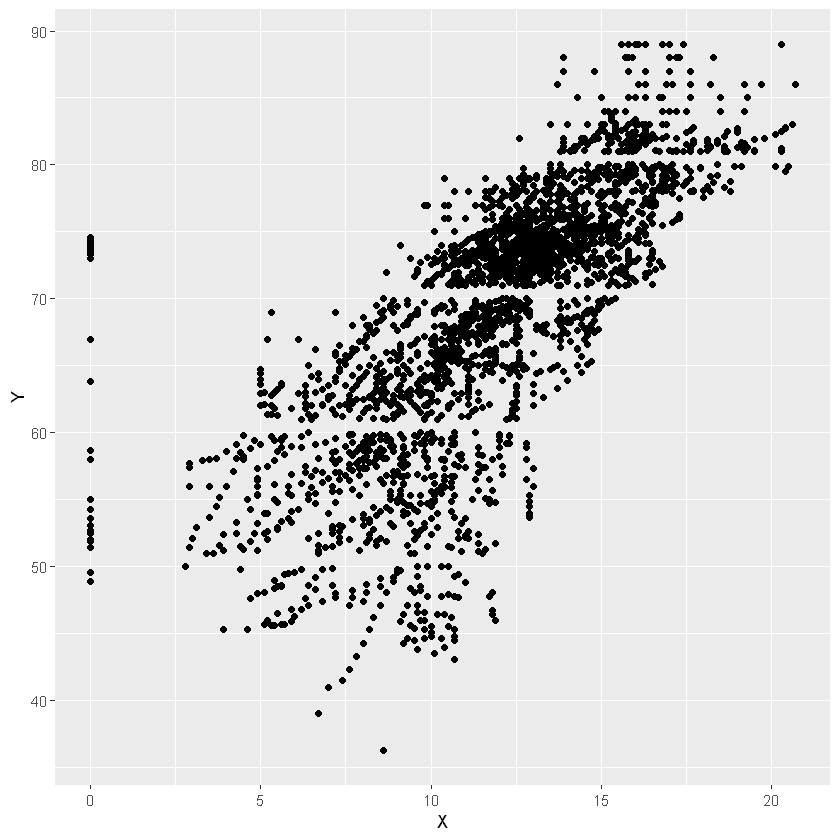

In [5]:
analysis(data$schooling, data$life_expectancy)

In [19]:
df <- data[!is.na(data$schooling) & !is.na(data$life_expectancy) & data$year == 2015,]


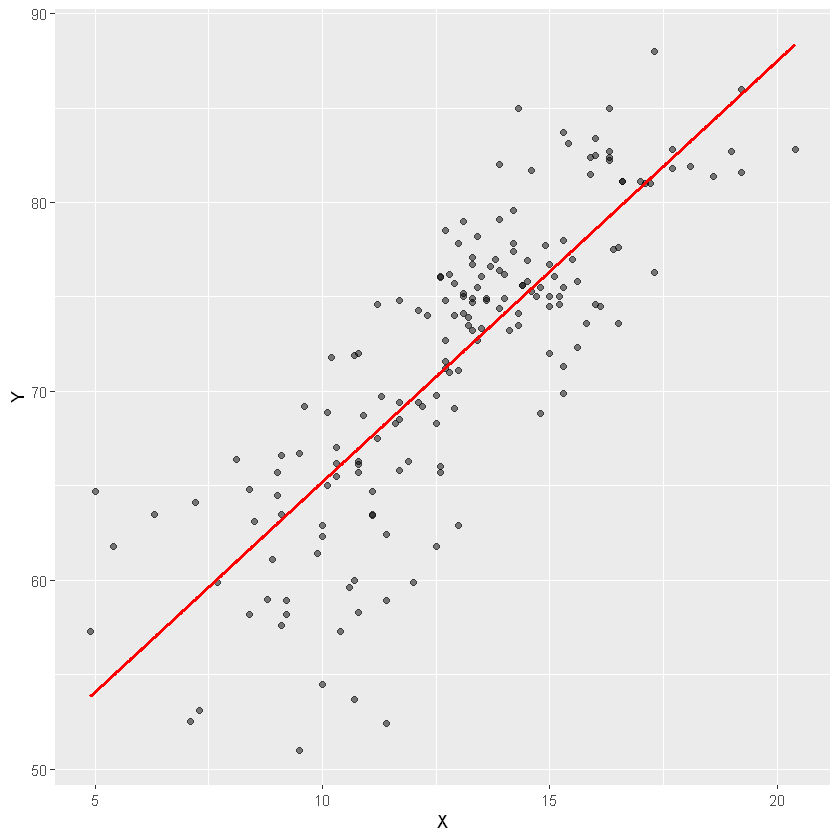

In [31]:
reg <- regression(df$schooling, df$life_expectancy)

In [32]:
reg

[1]  2.228727 42.901591

# Predykcja danych próba

In [30]:
b0 <- reg[2]
b1 <- reg[1]

[1] 2.228727

In [33]:
x <- df$schooling
y <- df$life_expectancy

In [34]:
e <- y - b1*x - b0

In [36]:
ks.test(e, 'pnorm', mean(e), sd(e)) #przyjmujemy że residua są z rozkładu normalnego

Warning message in ks.test(e, "pnorm", mean(e), sd(e)):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  e
D = 0.077247, p-value = 0.2532
alternative hypothesis: two-sided


In [38]:
sd(e)

[1] 4.561694

In [76]:
x_pred <- seq(17.5, 25, 0.05)

In [77]:
eps <- rnorm(length(x), 0, sd(e)) #szum
ksi <- rnorm(length(x_pred), 0, sd(e))

In [83]:
b1_est <- b1 +  (sum((x - mean(x))*eps))/(sum((x - mean(x))^2))
b0_est <- b0 + (b1 - b1_est)*mean(x) + mean(eps)

In [84]:
b1_est

[1] 2.215433

In [85]:
Y_pred <- b0 + b1*x_pred + ksi

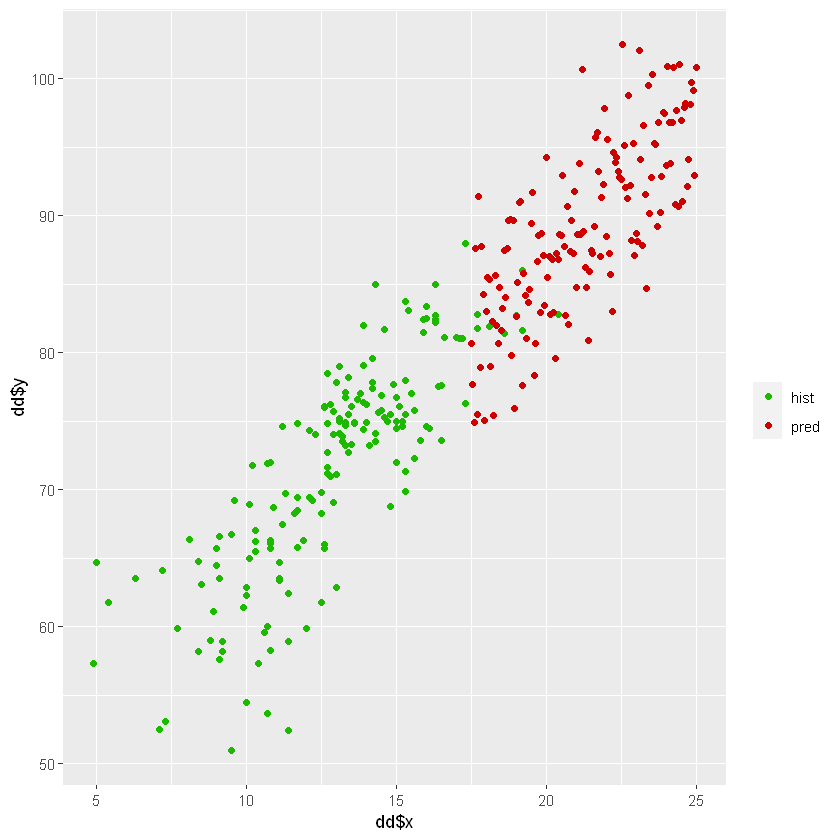

In [86]:
df_hist <- data.frame(x = x, y = y) %>% mutate(t = 'hist')
df_pred <- data.frame(x = x_pred, y = Y_pred) %>% mutate(t = 'pred')
dd <- rbind(df_hist, df_pred)

plt <- ggplot() + geom_point(aes(dd$x, dd$y, col=dd$t)) +
scale_color_manual(values=c('#1cb900', '#ce0000')) + labs(col="")
plt

In [87]:
alpha = 0.05
z <- qnorm(1 - alpha/2)
n <- length(x)
rel <- z*sd(e)*sqrt(1 + 1/n + (x_pred - mean(x))^2/sum((x - mean(x))^2))
Y_pred_est <- b0_est + b1_est*x_pred

In [102]:
l <- Y_pred_est - rel
r <- Y_pred_est + rel
l

[1] 73.10541 73.21478 73.32414 73.43349 73.54282 73.65214 73.76144 73.87073
  [9] 73.98000 74.08926 74.19850 74.30773 74.41694 74.52614 74.63532 74.74449
 [17] 74.85364 74.96278 75.07191 75.18102 75.29011 75.39919 75.50825 75.61730
 [25] 75.72634 75.83536 75.94436 76.05335 76.16233 76.27129 76.38024 76.48917
 [33] 76.59809 76.70699 76.81588 76.92475 77.03361 77.14245 77.25128 77.36009
 [41] 77.46889 77.57768 77.68645 77.79520 77.90395 78.01267 78.12138 78.23008
 [49] 78.33876 78.44743 78.55609 78.66473 78.77335 78.88196 78.99056 79.09914
 [57] 79.20770 79.31626 79.42479 79.53332 79.64183 79.75032 79.85880 79.96727
 [65] 80.07572 80.18415 80.29258 80.40099 80.50938 80.61776 80.72612 80.83448
 [73] 80.94281 81.05113 81.15944 81.26774 81.37602 81.48428 81.59253 81.70077
 [81] 81.80899 81.91720 82.02539 82.13357 82.24174 82.34989 82.45803 82.56615
 [89] 82.67426 82.78236 82.89044 82.99851 83.10656 83.21460 83.32262 83.43063
 [97] 83.53863 83.64661 83.75458 83.86254 83.97048 84.07840 84.18632 84.29422
[105] 84.40210 84.50997 84.61783 84.72567 84.83350 84.94132 85.04912 85.15691
[113] 85.26468 85.37245 85.48019 85.58793 85.69564 85.80335 85.91104 86.01872
[121] 86.12638 86.23404 86.34167 86.44930 86.55691 86.66450 86.77208 86.87965
[129] 86.98721 87.09475 87.20228 87.30979 87.41729 87.52478 87.63226 87.73972
[137] 87.84716 87.95460 88.06202 88.16943 88.27682 88.38420 88.49157 88.59892
[145] 88.70626 88.81359 88.92090 89.02820 89.13549 89.24276 89.35002

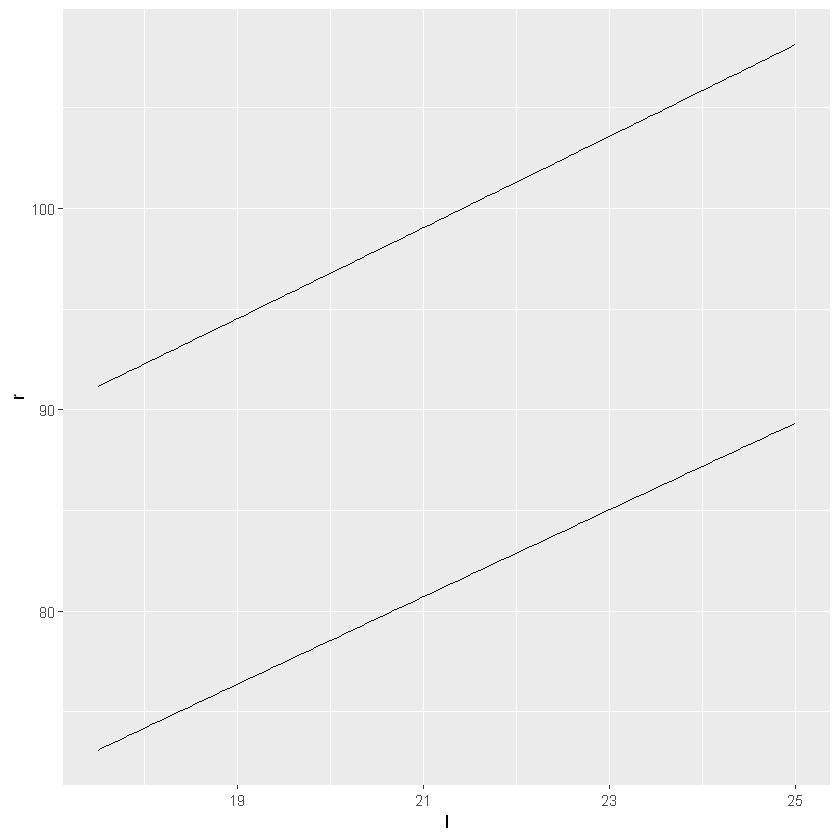

In [101]:
ggplot(data.frame(x = x_pred, l = l, r = r), mapping = aes(l, r)) + geom_line(aes(x, l)) + geom_line(aes(x, r))

# Analiza GDP

In [10]:
df2 <- data[(!is.na(data$GDP)) & (!is.na(data$life_expectancy)) & (data$year == 2015),]
scat2 <- ggplot(data = df2, mapping = aes(x = GDP, y = life_expectancy)) + geom_point()

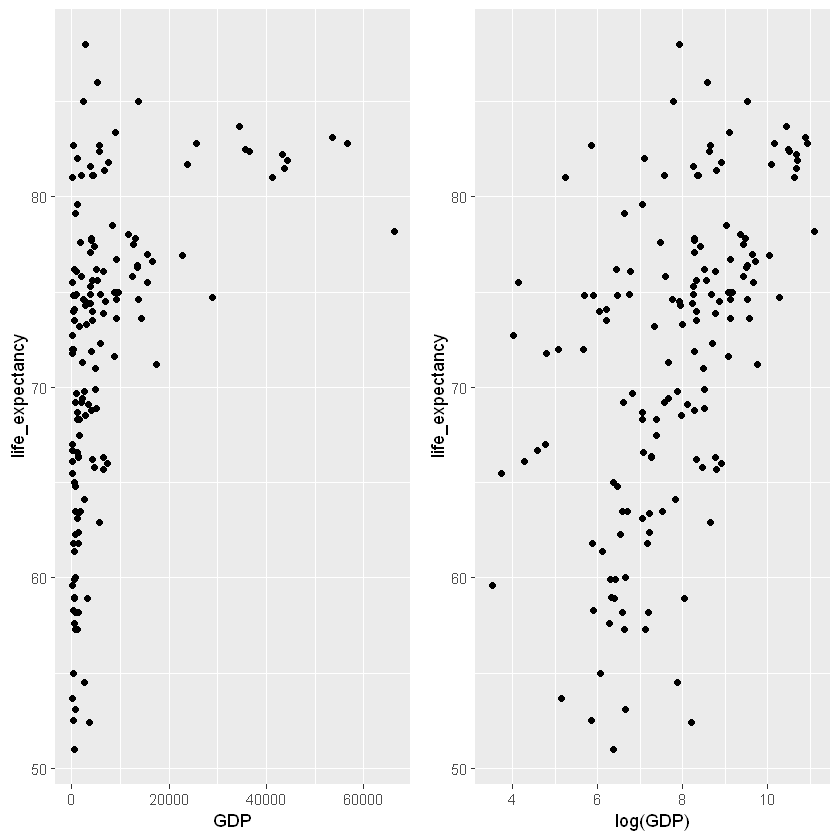

In [12]:
scat2_mod <- ggplot(data = df2, mapping = aes(x = log(GDP), y = life_expectancy)) + geom_point()
plot_grid(scat2, scat2_mod)

In [13]:
c(a1, b1) %<-% regression(log(df2$GDP), df2$life_expectancy, FALSE)
xs1 <- seq(min(log(df2$GDP)), max(log(df2$GDP)), 0.1)
reg2 <- ggplot() + geom_point(aes(log(df2$GDP), df2$life_expectancy), alpha = 0.5) + geom_line(aes(xs1, a1*xs1 + b1), col='red', linewidth=1)

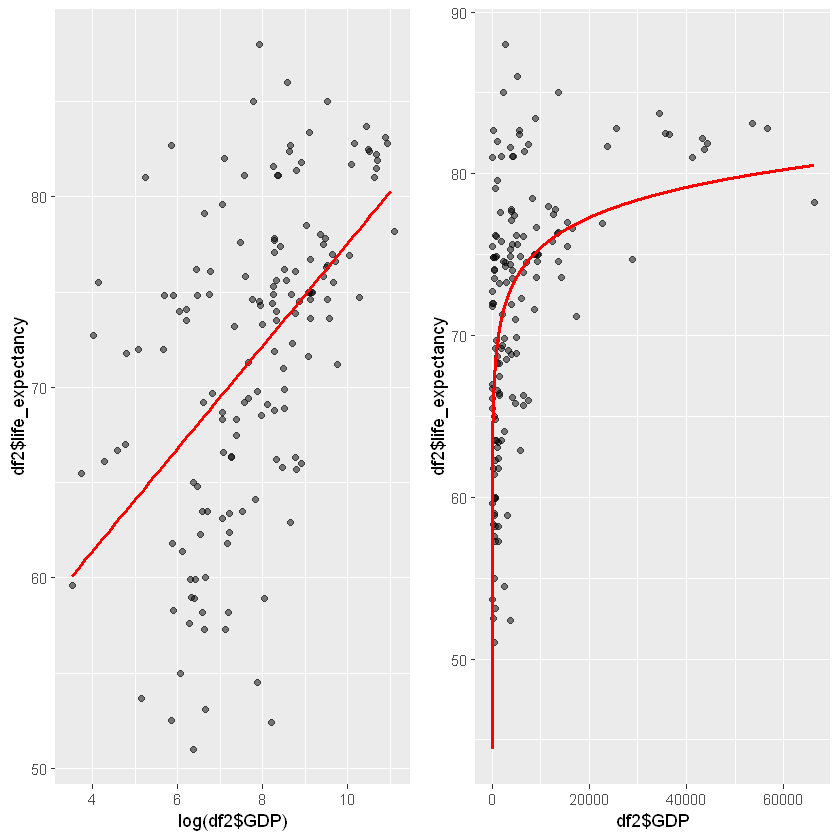

In [14]:
c(a2, b2) %<-% regression(log(df2$GDP), df2$life_expectancy, FALSE)
xs2 <- seq(0.1, max(df2$GDP), 10)
reg2_final <- ggplot() + geom_point(aes(df2$GDP, df2$life_expectancy), alpha = 0.5) + geom_line(aes(xs2, a2*log(xs2) + b2), col='red', linewidth=1)
plot_grid(reg2, reg2_final)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


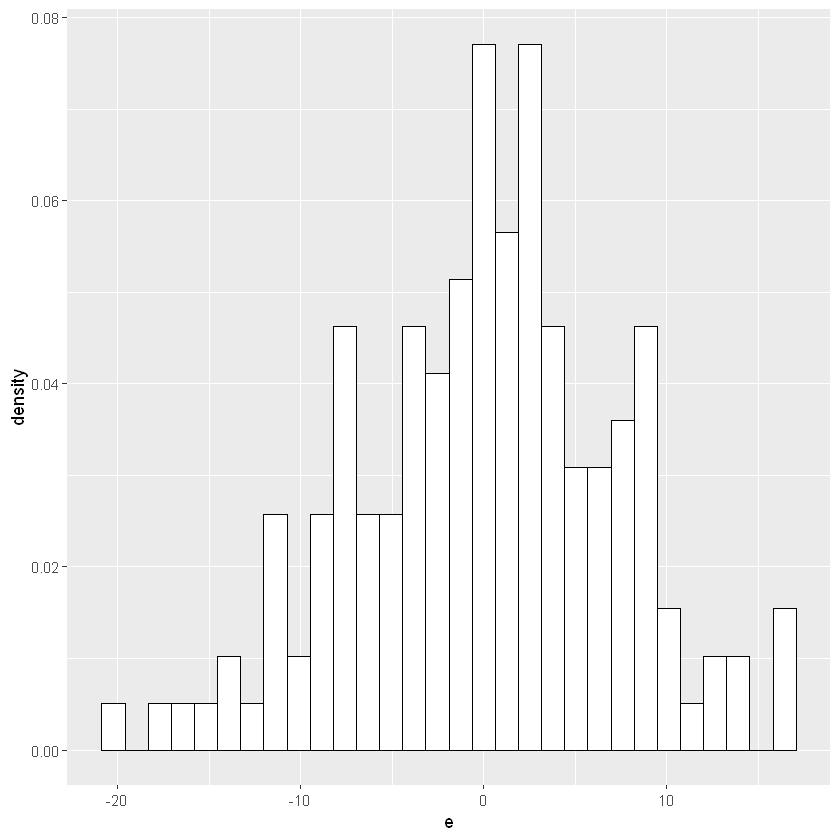

In [15]:
e <- df2$life_expectancy - a2*log(df2$GDP) - b2
hist_e <- ggplot(data.frame(e = e), aes(e)) + geom_histogram(aes(y = after_stat(density)), fill = 'white', color = 'black')
hist_e

In [16]:
mean(e)
sd(e)

[1] 5.282812e-15

[1] 7.069091